# Pattern Lattice Builder (PLB) runner

developed by Kow Kuroda (kow.kuroda@gmail.com)

created on 2024/10/18

modified on 2024/10/20

modifications
1. add compatibility with package format (2024/10/20)

In [25]:
## modules imports
import matplotlib
from matplotlib import font_manager as Font_manager
import csv
import pprint as pp

In [26]:
## imports
import gPLB as plb

## The following needs to be True only for debugging/development.
re_import_module = False
if re_import_module:
    import importlib
    importlib.reload (plb)

In [27]:
## inspect plb.py
content_check = False
if content_check:
    pp.pprint(dir(plb))

In [28]:
## Parameters
## managemental
verbose     = True

## internal variables
comment_escape = '#'
field_sep      = r","

## parameters for PLB
reflexive      = True
gap_mark       = "_"

## use Generalized Pattern Lattice or not
generalized    = True

## size filtering
size_filtering  = True
max_size        = 9

### settings for drawing
## full display for merged pattern lattice
draw_full_version_for_merged = False

## set font for Japanese character display
use_multibyte_chars = False
if use_multibyte_chars:
    ## select font
    multibyte_font_names = [    "IPAexGothic",  # 0 Multi-platform font
                                "Hiragino sans" # 1 Mac only
                            ]
    multibyte_font_name  = multibyte_font_names[0]
    ## tell where target fonts are
    system_font_dir = "/System/Library/Fonts/"
    user_font_dir = "/Users/kowk/Library/Fonts/"
    if multibyte_font_name == "IPAexGothic":
        Font_manager.fontManager.addfont(f"{user_font_dir}ipaexg.ttf")
    elif multibyte_font_name == "Hiragino sans":
        Font_manager.fontManager.addfont(f"{system_font_dir}ヒラギノ角ゴシック W0.ttc")
    ## check result
    matplotlib.rc('font', family = multibyte_font_name)
else:
    multibyte_font_name = None
    matplotlib.rcParams['font.family'] = "Sans-serif"
##
print(f"multibyte_font_name: {multibyte_font_name}")
print(f"matplotlib.rcParams['font.family']: {matplotlib.rcParams['font.family']}")    

multibyte_font_name: None
matplotlib.rcParams['font.family']: ['Sans-serif']


In [29]:
## graph layout selection
graph_layouts = [   'Multi_partite', # 0
                    'Graphviz', # 1
                    'Spring', # 2
                    'Planar', # 3
                    'Circular', # 4
                    'Shell', # 5
                    'Spectral', # 6
                    'Kamada_Kawai', # 7
                    'Fruchterman_Reingold', # 8
                    'ARF', # 8
                    'Breadth-First Search', # 8
                 ]
#
graph_layout = graph_layouts[0]
print(f"graph_layout: {graph_layout}")

graph_layout: Multi_partite


# Preparation

In [43]:
## select target file
import csv
data_dir = "sources"
data_names = [  'plb-XiY-wiper2b', 'plb-XiY-wiper2-phonetic', 'plb-XiY-m7', 'plb-XiY-wiper3-dual',
                'plb-inteY-max9',
                'plb-utau-naku-sinu', 'plb-utau-naku-sinu-smaller',
                ]

data_name = data_names[3]
data_file = f"{data_dir}/{data_name}.csv"
print(f"read data from: {data_file}")

read data from: sources/plb-XiY-wiper3-dual.csv


In [44]:
## reading data
with open(data_file, encoding = "utf-8") as file:
    data = list(csv.reader(file, delimiter = field_sep)) # Crucially list(..)

## discard comment lines that start with #
data = [ F for F in data if len(F) > 0 and not F[0][0] == comment_escape ]

## remove in-line comments
data_renewed = [ ]
for F in data:
    G = []
    for f in F:
        pos = f.find(comment_escape)
        if pos > 0:
            G.append(f[:pos])
            continue
        else:
            G.append(f)
    ##
    data_renewed.append(G)
##
data = data_renewed

In [45]:
## check result
import pprint as pp
pp.pprint(data)

[['w:w', 'i:ay', 'p:p', 'e:ə', 'r:r'],
 ['r:r', 'i:ay', 'd:d', 'e:ə', 'r:r'],
 ['w:w', 'i:ɪ', 'th:ð', 'e:ə', 'r:r'],
 ['w:w', 'i:ɪ', 'd:d', 'th:θ'],
 ['w:-', 'r:r', 'i:ay', 't:t', 'e:-'],
 ['w:-', 'h:w', 'i:ay', 't:t', 'e:-']]


# Process individual pattern lattices

In [46]:
## size filter
if size_filtering:
    data = [ x for x in data if len(x) <= max_size ]

In [47]:
## sampling
sampling = True
sampling_rate = 0.5
if sampling:
      import random
      data = random.sample(data, round(len(data) * sampling_rate))
##
pp.pprint(data)

[['w:-', 'r:r', 'i:ay', 't:t', 'e:-'],
 ['w:w', 'i:ɪ', 'd:d', 'th:θ'],
 ['w:-', 'h:w', 'i:ay', 't:t', 'e:-']]


In [48]:
## build pattern lattices from data
Lx = [ ]
for item in data:
    pat    = plb.Pattern(item)
    patlat = plb.PatternLattice(pat, reflexive = reflexive, generalized = generalized)
    if verbose:
            print(patlat)
    Lx.append(patlat)

#linked: ['_', '_', '_', '_', '_'] by ['_', '_', '_', '_', 'e:-']
#linked: ['_', '_', '_', '_', '_'] by ['_', '_', '_', 't:t', '_']
#linked: ['_', '_', '_', '_', '_'] by ['_', '_', 'i:ay', '_', '_']
#linked: ['_', '_', '_', '_', '_'] by ['_', 'r:r', '_', '_', '_']
#linked: ['_', '_', '_', '_', '_'] by ['w:-', '_', '_', '_', '_']
#linked: ['_', '_', '_', '_', '_', '_'] by ['_', '_', '_', '_', '_']
#linked: ['_', '_', '_', '_', '_', '_'] by ['_', '_', '_', '_', '_', 'e:-']
#linked: ['_', '_', '_', '_', '_', '_'] by ['_', '_', '_', '_', 'e:-', '_']
#linked: ['_', '_', '_', '_', '_', '_'] by ['_', '_', '_', '_', 't:t', '_']
#linked: ['_', '_', '_', '_', '_', '_'] by ['_', '_', '_', 'i:ay', '_', '_']
#linked: ['_', '_', '_', '_', '_', '_'] by ['_', '_', '_', 't:t', '_', '_']
#linked: ['_', '_', '_', '_', '_', '_'] by ['_', '_', 'i:ay', '_', '_', '_']
#linked: ['_', '_', '_', '_', '_', '_'] by ['_', '_', 'r:r', '_', '_', '_']
#linked: ['_', '_', '_', '_', '_', '_'] by ['_', 'r:r', '_', '_', 

#figsize_local: (12, 10.0)
#font_size: 10
#node_size: 12


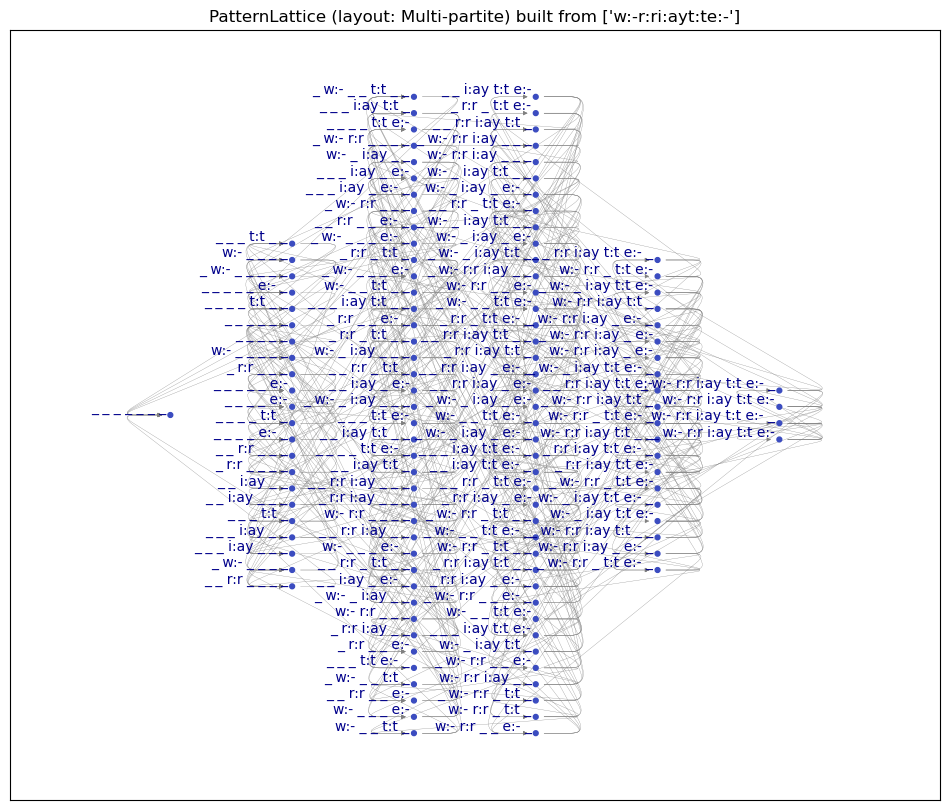

#figsize_local: (10, 5.0)
#font_size: 10
#node_size: 12


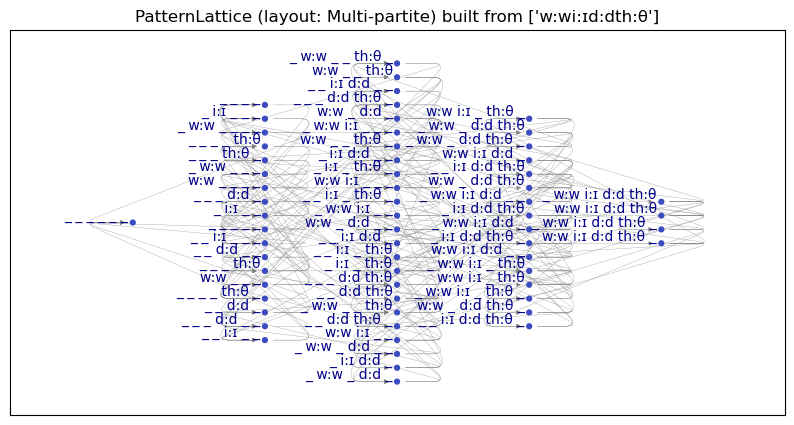

#figsize_local: (12, 10.0)
#font_size: 10
#node_size: 12


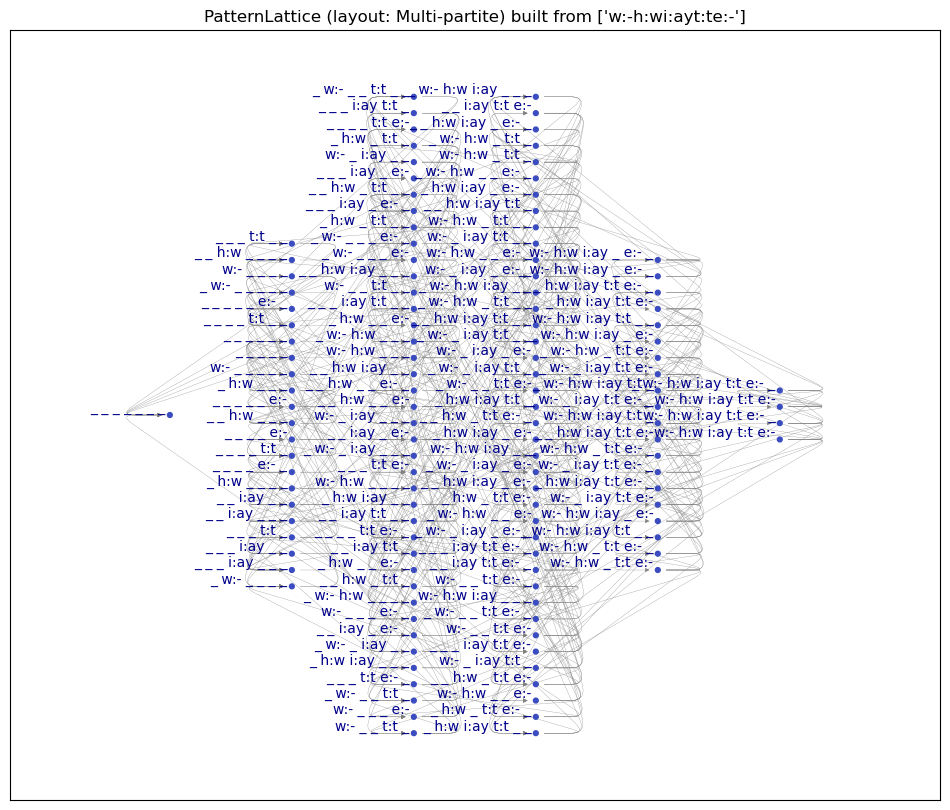

In [49]:
## draw pattern lattices individually
for patlat in Lx:
    #patlat.draw_diagrams (fig_size = (14, 18), node_size = 30, label_size = 10, font_name = multibyte_font_name)
	patlat.draw_diagrams (font_name = multibyte_font_name)

In [50]:
#raise "Stop execution"

# Process merged pattern lattice

In [51]:
## merge pattern lattices
import functools
M = functools.reduce (lambda La, Lb: La.merge_lattices (Lb, gen_links = True, reflexive = reflexive, show_steps = True, check = False), Lx)

# The following process was isolated for speeding up
if len(M.links) == 0:
    M.update_links (reflexive = reflexive)

#linked: ['_', '_'] by ['_']
#linked: ['_', '_', '_', '_', '_'] by ['_', '_', '_', '_']
#linked: ['_', '_', '_', '_', '_'] by ['_', '_', '_', '_']
#linked: ['_', '_', '_', '_', '_'] by ['_', '_', '_', '_']
#linked: ['_', '_', '_', '_', '_'] by ['_', '_', '_', '_', 'e:-']
#linked: ['_', '_', '_', '_', '_'] by ['_', '_', '_', 't:t', '_']
#linked: ['_', '_', '_', '_', '_'] by ['_', '_', 'i:ay', '_', '_']
#linked: ['_', '_', '_', '_', '_'] by ['_', 'r:r', '_', '_', '_']
#linked: ['_', '_', '_', '_', '_'] by ['w:-', '_', '_', '_', '_']
#linked: ['_', '_', '_', '_', '_'] by ['_', '_', '_', 'th:θ', '_']
#linked: ['_', '_', '_', '_', '_'] by ['_', '_', 'd:d', '_', '_']
#linked: ['_', '_', '_', '_', '_'] by ['_', 'i:ɪ', '_', '_', '_']
#linked: ['_', '_', '_', '_', '_'] by ['w:w', '_', '_', '_', '_']
#linked: ['_', '_', '_', '_', '_'] by ['_', '_', '_', '_', 'th:θ']
#linked: ['_', '_', '_', '_', '_'] by ['_', '_', '_', 'd:d', '_']
#linked: ['_', '_', '_', '_', '_'] by ['_', '_', 'i:ɪ', '_', '_']

In [52]:
## calculate z-scores
averages_by_rank = plb.calc_averages_by_rank (M.link_sources) # returns dictionary
stdevs_by_rank   = plb.calc_stdevs_by_rank (M.link_sources) # returns dictionary

source_zscores = {}
for i, link_source in enumerate(M.link_sources):
    rank    = plb.get_rank_of_list (link_source)
    value   = M.link_sources[link_source]
    zscore  = plb.calc_zscore (value, averages_by_rank[rank], stdevs_by_rank[rank])
    source_zscores[link_source] = zscore
    if verbose:
        print(f"#link_source {i}: {link_source} has {value} offspring(s) [{source_zscores[link_source]:.6f} at rank {rank}]")

## attach source_zscores to M
M.source_zscores.update(source_zscores)

#link_source 0: ('_', '_', '_', '_') has 23 offspring(s) [-1.344738 at rank 0]
#link_source 1: ('_', '_', '_', '_', '_') has 102 offspring(s) [1.051525 at rank 0]
#link_source 2: ('_', '_', '_', '_', '_', '_') has 77 offspring(s) [0.293214 at rank 0]
#link_source 3: ('_', '_', '_', '_', 'e:-') has 10 offspring(s) [0.885391 at rank 1]
#link_source 4: ('_', '_', '_', 't:t', '_') has 11 offspring(s) [1.084064 at rank 1]
#link_source 5: ('_', '_', 'i:ay', '_', '_') has 11 offspring(s) [1.084064 at rank 1]
#link_source 6: ('_', 'r:r', '_', '_', '_') has 1 offspring(s) [-0.902667 at rank 1]
#link_source 7: ('w:-', '_', '_', '_', '_') has 10 offspring(s) [0.885391 at rank 1]
#link_source 8: ('_', '_', '_', 't:t') has 1 offspring(s) [-0.902667 at rank 1]
#link_source 9: ('_', '_', 'i:ay', '_') has 1 offspring(s) [-0.902667 at rank 1]
#link_source 10: ('_', 'r:r', '_', '_') has 1 offspring(s) [-0.902667 at rank 1]
#link_source 11: ('w:-', '_', '_', '_') has 3 offspring(s) [-0.505321 at rank 1]


In [53]:
## check result
i = 0
for key, value in M.source_zscores.items():
    i += 1
    print(f"node {i} {key} has z-score: {value:.6f}")

node 1 ('_', '_', '_', '_') has z-score: -1.344738
node 2 ('_', '_', '_', '_', '_') has z-score: 1.051525
node 3 ('_', '_', '_', '_', '_', '_') has z-score: 0.293214
node 4 ('_', '_', '_', '_', 'e:-') has z-score: 0.885391
node 5 ('_', '_', '_', 't:t', '_') has z-score: 1.084064
node 6 ('_', '_', 'i:ay', '_', '_') has z-score: 1.084064
node 7 ('_', 'r:r', '_', '_', '_') has z-score: -0.902667
node 8 ('w:-', '_', '_', '_', '_') has z-score: 0.885391
node 9 ('_', '_', '_', 't:t') has z-score: -0.902667
node 10 ('_', '_', 'i:ay', '_') has z-score: -0.902667
node 11 ('_', 'r:r', '_', '_') has z-score: -0.902667
node 12 ('w:-', '_', '_', '_') has z-score: -0.505321
node 13 ('_', '_', '_', '_', 'e:-', '_') has z-score: 1.282737
node 14 ('_', '_', '_', 't:t', '_', '_') has z-score: 1.282737
node 15 ('_', '_', 'i:ay', '_', '_', '_') has z-score: 1.282737
node 16 ('_', 'r:r', '_', '_', '_', '_') has z-score: -0.902667
node 17 ('w:-', '_', '_', '_', '_', '_') has z-score: 1.084064
node 18 ('_', 

#pruning nodes with z-score less than 0
#pruning ('w:-', 'r:r', 'i:ay', 't:t', 'e:-', '_') with z-score -0.707107
#pruning ('_', 'w:-', 'r:r', 'i:ay', 't:t', 'e:-') with z-score -0.707107
#pruning ('w:-', 'h:w', 'i:ay', 't:t', 'e:-', '_') with z-score -0.707107
#pruning ('_', 'w:-', 'h:w', 'i:ay', 't:t', 'e:-') with z-score -0.707107
#pruning ('_', 'r:r', 'i:ay', 't:t', 'e:-') with z-score -0.930556
#pruning ('w:-', 'r:r', '_', 't:t', 'e:-') with z-score -0.930556
#pruning ('w:-', 'r:r', 'i:ay', '_', 'e:-') with z-score -0.930556
#pruning ('w:-', 'r:r', 'i:ay', 't:t', '_') with z-score -0.138593
#pruning ('_', 'r:r', 'i:ay', 't:t', 'e:-', '_') with z-score -0.930556
#pruning ('w:-', 'r:r', '_', 't:t', 'e:-', '_') with z-score -0.138593
#pruning ('w:-', 'r:r', 'i:ay', '_', 'e:-', '_') with z-score -0.138593
#pruning ('w:-', 'r:r', 'i:ay', 't:t', '_', '_') with z-score -0.138593
#pruning ('_', '_', 'r:r', 'i:ay', 't:t', 'e:-') with z-score -0.930556
#pruning ('_', 'w:-', 'r:r', '_', 't:t

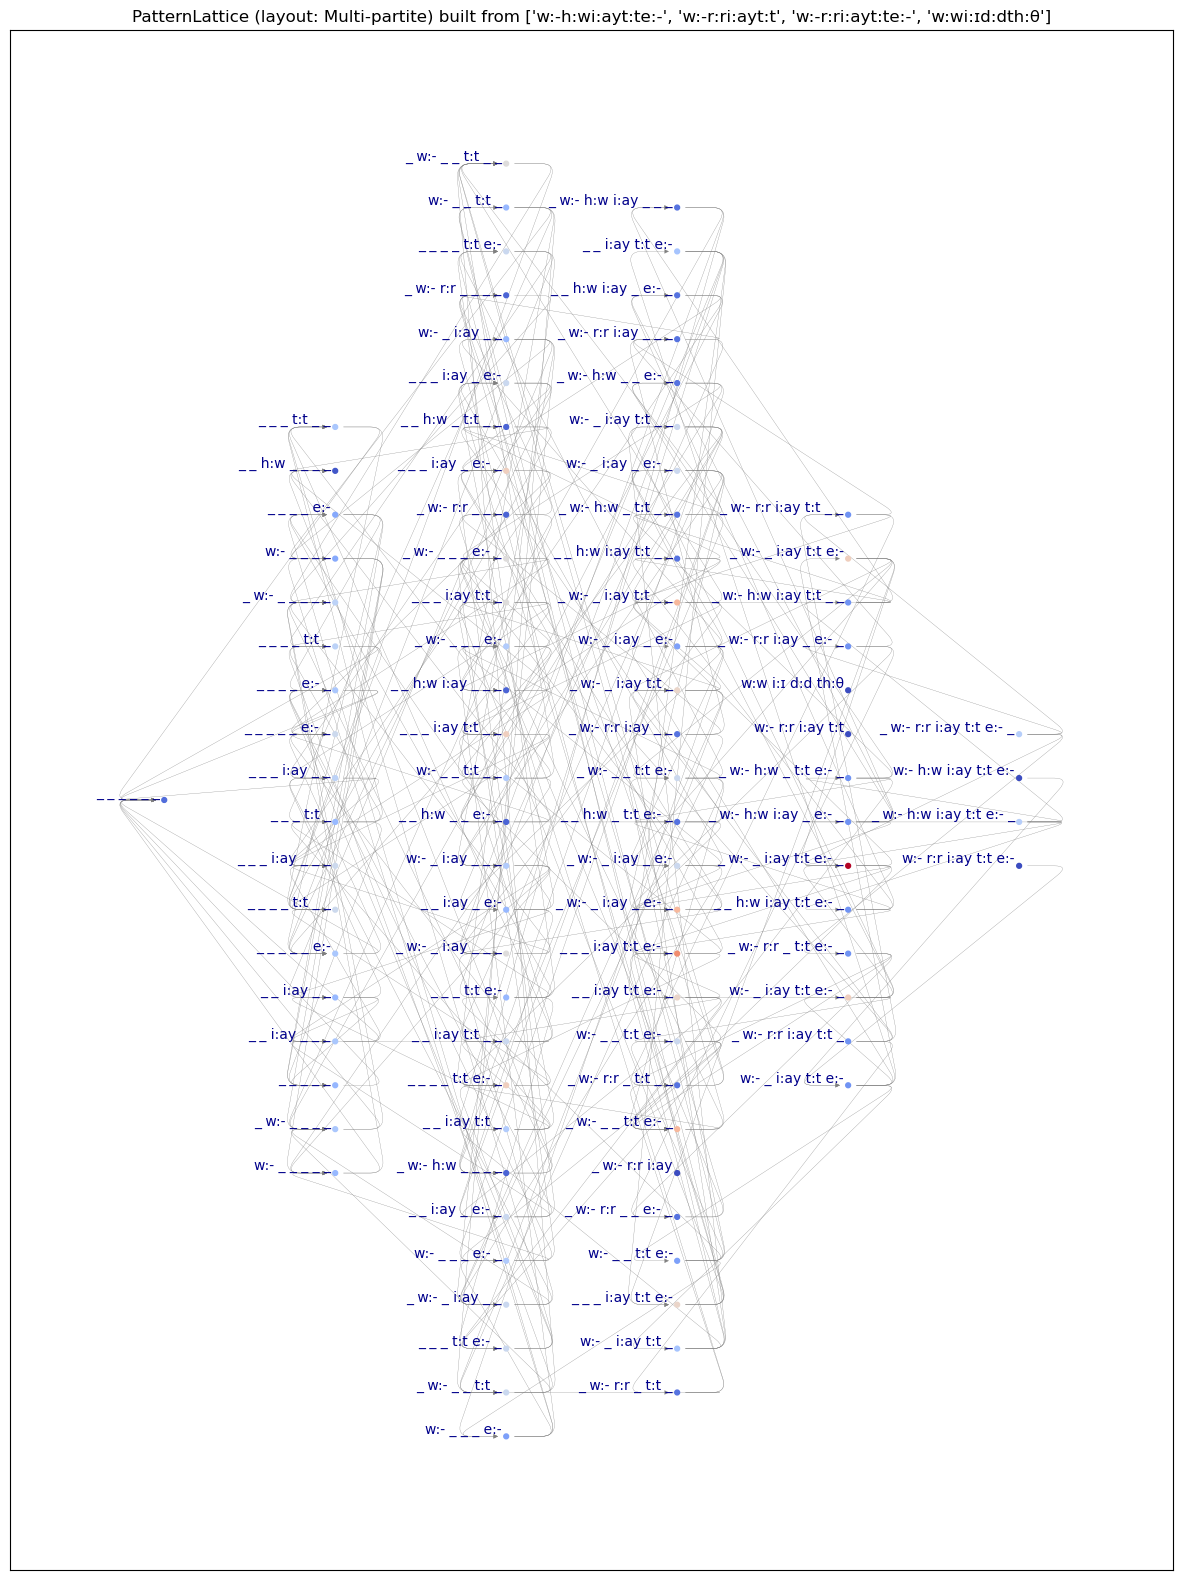

In [58]:
## draw a pruned diagram from the merged lattice
graph_layouts = [   'Multi_partite', # 0
                    'Graphviz', # 1
                    'Spring', # 2
                    'Planar', # 3
                    'Circular', # 4
                    'Shell', # 5
                    'Spectral', # 6
                    'Kamada_Kawai', # 7
                    'Fruchterman_Reingold', # 8
                    'ARF', # 8
                    'Breadth-First Search', # 8
                 ]
##
layout = graph_layouts[0]
scale_factor       = 3
zscore_lowerbound  = 0

adjusted = True
if adjusted:
   M.draw_diagrams (layout = layout, zscore_lowerbound = zscore_lowerbound, scale_factor = scale_factor, fig_size = (15, 20), label_size = 16, node_size = 52, font_name = multibyte_font_name, check = False)
else:
   M.draw_diagrams (layout = layout, zscore_lowerbound = zscore_lowerbound, scale_factor = scale_factor, font_name = multibyte_font_name, check = False)

In [55]:
## draw a full diagram from the merged lattice
if draw_full_version_for_merged:
    layout = graph_layouts[0]
    zscore_lowerbound  = None
    scale_factor       = 3
    ##
    M.draw_diagrams (layout = layout, zscore_lowerbound = zscore_lowerbound,
        scale_factor = scale_factor, fig_size = (24, 60), label_size = 12, node_size = 33, font_name = multibyte_font_name, check = False)